In [1]:
import numpy as np
from scipy import optimize
from scipy.integrate import solve_ivp
from TC_class import terracotta as terra

In [2]:
import matplotlib
import matplotlib.pyplot as plt
fontsize = 7
font = {'size'   : fontsize}
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.facecolor']='white'
from matplotlib import rc
rc('font',**{'size': fontsize, 'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath,xfrac}')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.2
plt.rcParams['ytick.major.width'] = 0.2
plt.rcParams['xtick.minor.width'] = 0.2
plt.rcParams['ytick.minor.width'] = 0.2

In [3]:
def stress_control(x, state, dot_gamma, D_inf, t):
    D = state[0]; dot_D = state[1]
    phi = state[2]; epsilon_el = state[3:9]; Tm = state[9]; H = state[34]
    sigma_el = state[10:16]; sigma = state[22:28]
    epsilon = state[16:22]
    dot_eps_update = state[28:34]
    
    dot_eps_n = x[0] # normal strain rate
    dot_epsilon = np.array([dot_eps_n, 0.0, 0.0, 0.0, 0.0, dot_gamma]) # strain rate vector
    Tau = sigma[-1] # shear stress
    ddot_D = khat*(D_inf-D)-Nhat*Tau+etahat*(V_inf-dot_D) # slip acceleration
    ddot_gamma = ddot_D/H0 # shear strain acceleration

    dot_H = -dot_eps_n*H0 # rate of the thickness
    dot_phi = TC.evol_phi(phi, dot_epsilon) # evolution eq. solid fraction
    dot_Tm = TC.evol_Tm(Tm, dot_epsilon) # evolution eq. meso-temperature
    dot_epsilon_el = TC.evol_eps_e(phi, Tm, sigma_el, dot_epsilon) # evolution eq. elastic strain 
    ddot_epsilon = np.array([0.0, 0.0, 0.0, 0.0, 0.0, ddot_gamma]) # strain acceleration vector
    if t!=0.:
        ddot_epsilon[0] = (dot_epsilon[0]-dot_eps_update[0])/t
    else:
        ddot_epsilon[0] = 0.0    
    dot_sigma_el = TC.evol_sigmaE(sigma_el, phi, dot_phi, epsilon_el, dot_epsilon_el) # rate of the elastic stress
    dot_sigmaD = TC.evol_sigmaD(Tm, dot_Tm, dot_eps_update, ddot_epsilon) # rate of the viscous stress
    dot_pT = TC.evol_pT(Tm, dot_Tm) # rate of the thermodynamic pressure
    dot_sigma = dot_sigma_el+dot_sigmaD + dot_pT*np.array([1,1,1,0,0,0]) # rate of the total stress    
    return dot_sigma[0]/sigma[0] # return normalised rate of the normal stress 


def ODE_TCspring(t, state):
    D = state[0]; dot_D = state[1]
    phi = state[2]; epsilon_el = state[3:9]; Tm = state[9]; H = state[34]
    sigma_el = state[10:16]; sigma = state[22:28]
    epsilon = state[16:22]
    dot_eps_update = state[28:34]

    D_inf = V_inf*t # far-field slip
    dot_gamma = dot_D/H0 # shear strain rate
    # compute normal velocity to ensure constant normal stress
    dot_eps_n = optimize.root(stress_control,
                              args=(state,dot_gamma,D_inf,t),
                              x0=dot_eps_update[0],
                              method='hybr',
                              tol=1e-5).x[0]
    dot_epsilon = np.array([dot_eps_n, 0.0, 0.0, 0.0, 0.0, dot_gamma]) # strain rate vector

    Tau = sigma[-1] # shear stress
    ddot_D = khat*(D_inf-D)-Nhat*Tau+etahat*(V_inf-dot_D) # slip acceleration
    ddot_gamma = ddot_D/H0 # shear strain acceleration

    dot_H = -dot_eps_n*H0 # rate of the thickness
    dot_phi = TC.evol_phi(phi, dot_epsilon) # evolution eq. solid fraction
    dot_Tm = TC.evol_Tm(Tm, dot_epsilon) # evolution eq. meso-temperature
    dot_epsilon_el = TC.evol_eps_e(phi, Tm, sigma_el, dot_epsilon) # evolution eq. elastic strain 
    ddot_epsilon = np.array([0.0, 0.0, 0.0, 0.0, 0.0, ddot_gamma]) # strain acceleration vector
    if t!=0.:
        ddot_epsilon[0] = (dot_epsilon[0]-dot_eps_update[0])/t
    else:
        ddot_epsilon[0] = 0.0    
    dot_sigma_el = TC.evol_sigmaE(sigma_el, phi, dot_phi, epsilon_el, dot_epsilon_el) # rate of the elastic stress
    dot_sigmaD = TC.evol_sigmaD(Tm, dot_Tm, dot_eps_update, ddot_epsilon) # rate of the viscous stress
    dot_pT = TC.evol_pT(Tm, dot_Tm) # rate of the thermodynamic pressure
    dot_sigma = dot_sigma_el+dot_sigmaD + dot_pT*np.array([1,1,1,0,0,0]) # rate of the total stress    
    return np.hstack((dot_D, ddot_D, dot_phi, dot_epsilon_el, dot_Tm, dot_sigma_el, dot_epsilon, dot_sigma, ddot_epsilon, dot_H)) # return rates of the state

In [4]:
# In-situ properties
Ls = 1.
Gs = 10.e+9
ρs = 2500.
ζs = 0.0
v_inf = 1e-2 # m/year
s_per_year = 60*60*(24*365)
v_inf = v_inf/s_per_year
vs = np.sqrt(Gs/ρs)

# Material parameters
K, G = 7*26e+8, 7*10e+8
M = 0.75
ω = 0.5
λ = 10.
p1 = 3000e+6
c = 100000
r = 1.0
η = 0.1
Γ = 1.
a = r*c

# Initial conditions
h0 = 1e-4 # Thickness
σn0 = 40e+6 # Normal stress
OCR = 2.6 # Consolidation ratio 

In [5]:
# Characteristic length, time, and temperature
D = h0
P = 10.e6
T = D/v_inf
θ = 1/T*np.sqrt(c/(3*η))

# Non-dimensional quantities
V_inf = T/D*v_inf
H0 = h0/D
Nhat = P*T**2/(ρs*Ls*D)
khat = (vs*T/Ls)**2
etahat = 2*ζs*vs/Ls*T

In [6]:

# Compute non-dimensional material parameters
nondim_K = K/P
nondim_G = G/P
nondim_p1 = p1/P
nondim_c = c/(T*θ)
nondim_Γ = Γ*P/θ**2
nondim_r = a/c
nondim_η = η*θ*T

# Call TC class
TC = terra(nondim_K, nondim_G, M, ω, λ, nondim_p1, nondim_c, nondim_r, nondim_η, nondim_Γ)

# Compute initial material state (assuming isotropic compression)
pe0 = σn0/P
phi0 = (pe0*OCR/TC.pI)**(1/TC.λ)
ev0 = TC.find_ev0(pe0,phi0)
eps_e0 = np.zeros(6)
eps_e0[:3] = ev0/3
sig_e0 = np.zeros(6)
sig_e0[:3] = pe0
Tm0 = np.zeros(1)
Tm0 /= θ

# Initial ODE state
D0 = 0.0
V0 = 0.0
initial_state = np.hstack((D0, V0, phi0, eps_e0, Tm0, sig_e0, eps_e0, sig_e0, np.zeros(6), H0))

In [7]:
# Absolute tolerances (solver)
tol_e = 1.; tol_s = 1; tol_T = 1.; tol_h = 1.; tol_d = 1.; tol_v = 1.; tol_v = 1e5
tol = np.array([tol_d,tol_v,
                1.0,
                tol_e, tol_e, tol_e, tol_e, tol_e, tol_e,
                tol_T,
                tol_s, tol_s, tol_s, tol_s, tol_s, tol_s,
                tol_e, tol_e, tol_e, tol_e, tol_e, tol_e,
                tol_s, tol_s, tol_s, tol_s, tol_s, tol_s,
                tol_e/tol_T, tol_e/tol_T, tol_e/tol_T, tol_e/tol_T, tol_e/tol_T, tol_e/tol_T,
                tol_h])

In [9]:
t_final = 10000
time = np.array([0.0])
macro_dt = 1
state_hist = np.array([initial_state])

while time[-1]<t_final:
    result = solve_ivp(ODE_TCspring,
                       t_span = [time[-1], time[-1]+macro_dt],
                       y0 = state_hist[-1],
                       dense_output = True,
                       first_step = macro_dt*1e-6,
                       atol = 1.e-6*tol,
                       rtol = 1.e-5,
                       method = 'Radau'
                      )
    state_hist = np.vstack((state_hist, result.y.T))
    time = np.hstack((time, result.t))
    print('Converged:',result.success,' Slip:', np.float32(state_hist[-1,0]))

Converged: True  Slip: 0.0029524649
Converged: True  Slip: 0.005948333
Converged: True  Slip: 0.009028898
Converged: True  Slip: 0.0122318175
Converged: True  Slip: 0.015590546
Converged: True  Slip: 0.019134715
Converged: True  Slip: 0.022891277
Converged: True  Slip: 0.02688609
Converged: True  Slip: 0.031145714
Converged: True  Slip: 0.035699334
Converged: True  Slip: 0.040580787
Converged: True  Slip: 0.045830913
Converged: True  Slip: 0.05150044
Converged: True  Slip: 0.057653893
Converged: True  Slip: 0.06437525
Converged: True  Slip: 0.07177662
Converged: True  Slip: 0.0800124
Converged: True  Slip: 0.08930369
Converged: True  Slip: 0.09998378
Converged: True  Slip: 0.1125918
Converged: True  Slip: 0.1280927
Converged: True  Slip: 0.14851625
Converged: True  Slip: 0.17964467
Converged: True  Slip: 0.26954243


/home/filippo/torchenv/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:346: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/home/filippo/torchenv/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:315: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/home/filippo/torchenv/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:345: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/filippo/torchenv/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:367: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


Converged: True  Slip: 7.971311
Converged: True  Slip: 8.027796
Converged: True  Slip: 8.078749
Converged: True  Slip: 8.148401
Converged: True  Slip: 12.528166
Converged: True  Slip: 12.619883
Converged: True  Slip: 12.671363
Converged: True  Slip: 12.725734
Converged: True  Slip: 12.820276
Converged: True  Slip: 17.200607
Converged: True  Slip: 17.26427
Converged: True  Slip: 17.31454
Converged: True  Slip: 17.376085
Converged: True  Slip: 21.599905
Converged: True  Slip: 21.852312
Converged: True  Slip: 21.906557
Converged: True  Slip: 21.9584
Converged: True  Slip: 22.034307
Converged: True  Slip: 26.419489
Converged: True  Slip: 26.497107
Converged: True  Slip: 26.547861
Converged: True  Slip: 26.604279
Converged: True  Slip: 26.717205
Converged: True  Slip: 31.07899
Converged: True  Slip: 31.138329
Converged: True  Slip: 31.188898
Converged: True  Slip: 31.254488
Converged: True  Slip: 35.610912
Converged: True  Slip: 35.725388
Converged: True  Slip: 35.777943
Converged: True  Sl

KeyboardInterrupt: 

In [10]:
state = state_hist.T
d = state[0]
v = state[1]
phi = state[2]
epsilon_el = state[3:9]
Tm = state[9]
sigma_el = state[10:16]
epsilon = state[16:22]
sigma = state[22:28]
dot_epsilon = state[28:34]
h = state[34]


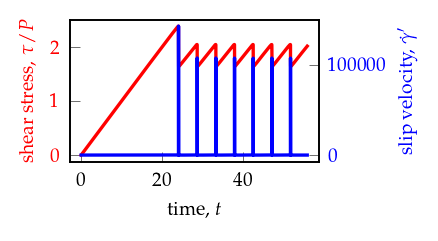

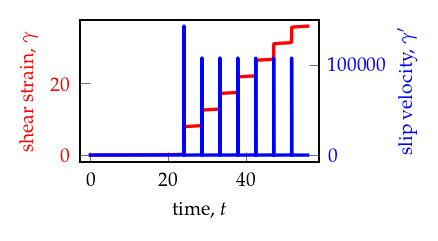

In [11]:
fig, ax1 = plt.subplots(1, 1, dpi=200, figsize=(2.2, 1.25), tight_layout=True)
color = 'red'
ax1.set_xlabel('time, $t$')
ax1.set_ylabel(r'shear stress, $\tau/P$', color=color)
ax1.plot(time,sigma[-1], color=color, marker='o',markersize=0,linewidth=1.2)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'blue'
ax2.set_ylabel(r"slip velocity, $\dot{\gamma}'$", color=color)  
ax2.plot(time,v, color=color,marker='o',markersize=0,linewidth=1.2)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

fig, ax1 = plt.subplots(1, 1, dpi=200, figsize=(2.2, 1.25), tight_layout=True)
color = 'red'
ax1.set_xlabel('time, $t$')
ax1.set_ylabel(r'shear strain, $\gamma$', color=color)
ax1.plot(time,d, color=color, marker='o',markersize=0,linewidth=1.2)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx() 
color = 'blue'
ax2.set_ylabel(r"slip velocity, ${\gamma'}$", color=color)  
ax2.plot(time,v, color=color,marker='o',markersize=0,linewidth=1.2)
ax2.tick_params(axis='y', labelcolor=color)
# fig.tight_layout()  
plt.show()

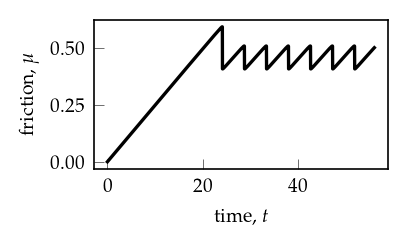

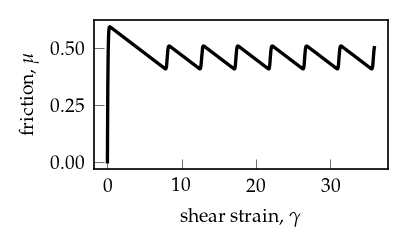

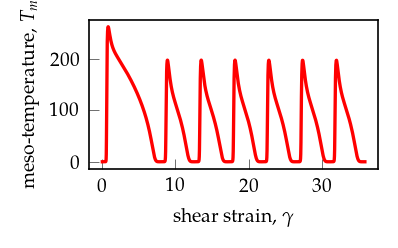

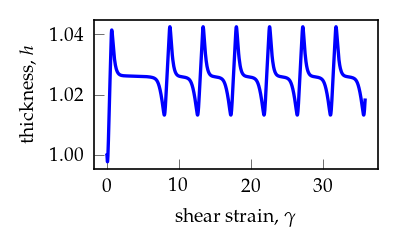

In [12]:

fig = plt.figure(dpi=200, figsize=(2.,1.25), tight_layout=True)
ax = fig.subplots(1)
ax.plot(time,
        sigma[-1]/sigma[0],color='black',linewidth=1.2)
ax.set_ylabel(r'friction, $\mu$')
ax.set_xlabel(r'time, $t$')
plt.show()


fig = plt.figure(dpi=200, figsize=(2.,1.25), tight_layout=True)
ax = fig.subplots(1)
ax.plot(d,
        sigma[-1]/sigma[0],color='black',linewidth=1.2)
ax.set_ylabel(r'friction, $\mu$')
ax.set_xlabel(r'shear strain, $\gamma$')
plt.show()


fig = plt.figure(dpi=200, figsize=(2.,1.25), tight_layout=True)
ax = fig.subplots(1)
ax.plot(d,
        θ*Tm,color='red',linewidth=1.2)
ax.set_ylabel(r'meso-temperature, $T_m$')
ax.set_xlabel(r'shear strain, $\gamma$')
plt.show()


fig = plt.figure(dpi=200, figsize=(2.,1.25), tight_layout=True)
ax = fig.subplots(1)
ax.plot(d,
        h,color='blue',linewidth=1.2)
ax.set_ylabel(r'thickness, $h$')
ax.set_xlabel(r'shear strain, $\gamma$')
plt.show()




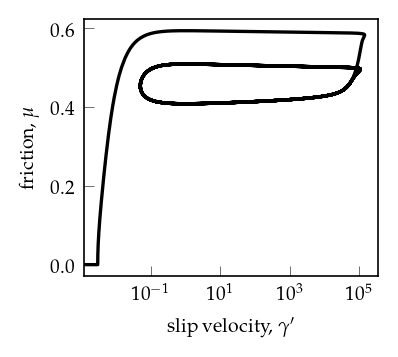

In [13]:
fig = plt.figure(dpi=200, figsize=(2.,1.8), tight_layout=True)
ax = fig.subplots(1)
ax.semilogx(v/V_inf,
        sigma[-1]/sigma[0],color='black',linewidth=1.2)
ax.set_ylabel(r'friction, $\mu$')
ax.set_xlabel(r"slip velocity, $\gamma'$")
plt.show()

In [14]:
from scipy.interpolate import UnivariateSpline
ht = UnivariateSpline(time, h, k=3, s=1e-10)
dhdt = ht.derivative()

/tmp/ipykernel_51709/2584904417.py:3: RuntimeWarning: divide by zero encountered in divide
  ax.plot(-dhdt(time)/(v/V_inf),


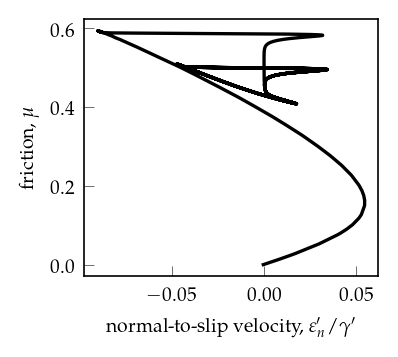

In [15]:
fig = plt.figure(dpi=200, figsize=(2.,1.8), tight_layout=True)
ax = fig.subplots(1)
ax.plot(-dhdt(time)/(v/V_inf),
        sigma[-1]/sigma[0],color='black',linewidth=1.2)
ax.set_ylabel(r'friction, $\mu$')
ax.set_xlabel(r"normal-to-slip velocity, $\varepsilon_n'/\gamma'$")
plt.show()